# This project is about predicting the temperature 12 hours from now given a set of past features. The data is from Germany for about 7 years at the hourly granularity 

In [1]:
import keras
from keras import layers
from keras.datasets import imdb
from keras.utils import timeseries_dataset_from_array
import numpy as np
from matplotlib import pyplot as plt
import os

# Read the data from the csv file (do not worry); the header gives you the meaning of the features

In [2]:
fname = os.path.join("../datasets/jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


# These lines compute the temperature (the target) and the raw_data (the features). The raw_data also contains the temperature since past temperature will be used to predict the next temperature

In [3]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

# Define the proper number of samples for the training, testing, and validation sets; do not create new sets

In [4]:
num_train_samples = int(len(lines) * 0.7)
num_val_samples = int(len(lines) * 0.2)
num_test_samples = len(lines) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
print("total:",num_train_samples + num_val_samples + num_test_samples)

num_train_samples: 294385
num_val_samples: 84110
num_test_samples: 42056
total: 420551


# Normalize the raw data

In [5]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# This is the utility code to generate the data as discussed in the videos

In [6]:
sequence_length = 120
lookahead = 12 # predict 12 hours in the future
delay = (sequence_length + lookahead - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples-1)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples-1)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
    end_index=num_train_samples + num_val_samples + num_test_samples-delay-1)


# Now define the LSTM model, plot the results;

In [7]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1],))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10


1150/1150 [==============================] - 216s 185ms/step - loss: 6.8254 - mae: 1.7272 - val_loss: 8.3398 - val_mae: 2.3465
Epoch 2/10
1150/1150 [==============================] - 200s 174ms/step - loss: 2.2518 - mae: 1.0570 - val_loss: 5.6772 - val_mae: 1.9021
Epoch 3/10
1150/1150 [==============================] - 205s 178ms/step - loss: 1.7287 - mae: 0.9397 - val_loss: 3.7264 - val_mae: 1.5757
Epoch 4/10
1150/1150 [==============================] - 208s 181ms/step - loss: 1.5310 - mae: 0.8882 - val_loss: 3.2651 - val_mae: 1.4642
Epoch 5/10
1150/1150 [==============================] - 216s 188ms/step - loss: 1.4298 - mae: 0.8588 - val_loss: 2.7557 - val_mae: 1.3085
Epoch 6/10
1150/1150 [==============================] - 207s 180ms/step - loss: 1.3546 - mae: 0.8371 - val_loss: 2.5195 - val_mae: 1.2241
Epoch 7/10
1150/1150 [==============================] - 200s 174ms/step - loss: 1.3126 - mae: 0.8239 - val_loss: 2.3253 - val_mae: 1.1786
Epoch 8/10
1150/1150 [=======================

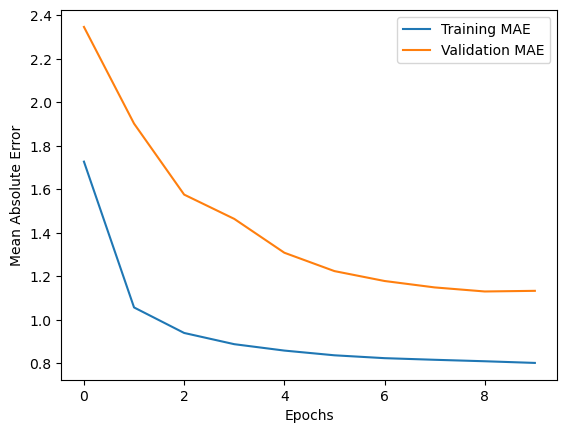

In [11]:
# Plot training results
import matplotlib.pyplot as plt

plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

164/164 [==============================] - 13s 78ms/step - loss: 1.7550 - mae: 1.0232
Test Loss: 1.7550, Test MAE: 1.0232
164/164 [==============================] - 12s 71ms/step


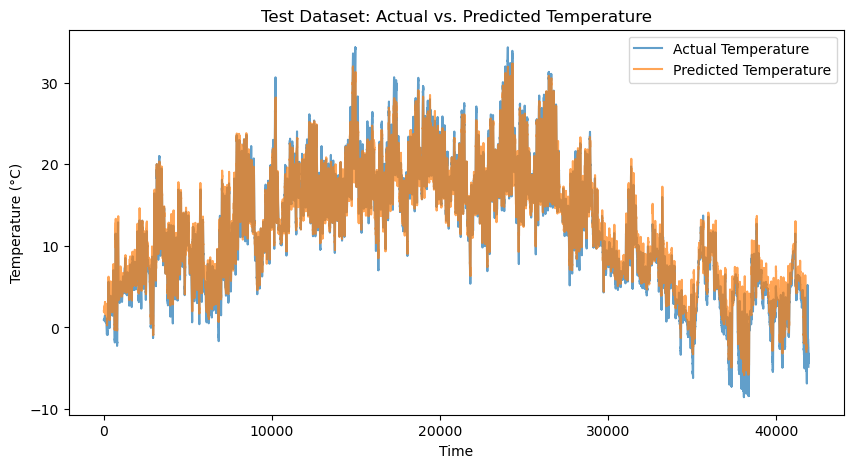

In [12]:
# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Generate predictions for the test dataset
predictions = model.predict(test_dataset)

# Plot actual vs. predicted temperature values
import matplotlib.pyplot as plt

actual_temperatures = temperature[num_train_samples + num_val_samples + delay : num_train_samples + num_val_samples + num_test_samples]

plt.figure(figsize=(10, 5))
plt.plot(actual_temperatures, label="Actual Temperature", alpha=0.7)
plt.plot(predictions, label="Predicted Temperature", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Test Dataset: Actual vs. Predicted Temperature")
plt.show()

In [1]:
import keras
from keras import layers
from keras.datasets import imdb
from keras.utils import timeseries_dataset_from_array
import numpy as np
from matplotlib import pyplot as plt
import os

fname = os.path.join("../datasets/pollution.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)

['date', 'pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']


In [2]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]


num_train_samples = int(len(lines) * 0.7)
num_val_samples = int(len(lines) * 0.2)
num_test_samples = len(lines) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
print("total:",num_train_samples + num_val_samples + num_test_samples)


num_train_samples: 30659
num_val_samples: 8760
num_test_samples: 4381
total: 43800


In [3]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


sequence_length = 120
lookahead = 12 # predict 12 hours in the future
delay = (sequence_length + lookahead - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples-1)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples-1)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
    end_index=num_train_samples + num_val_samples + num_test_samples-delay-1)


In [4]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1],))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 64)                18432     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10
120/120 [==============================] - 22s 154ms/step - loss: 122.4729 - mae: 9.3724 - val_loss: 99.3990 - val_mae: 8.1604
Epoch 2/10
120/120 [==============================] - 19s 155ms/step - loss: 71.4688 - mae: 7.0519 - val_loss: 66.5579 - val_mae: 6.3157
Epoch 3/10
120/120 [==============================] - 17s 139ms/step - loss: 45.4870 - mae: 5.4944 - val_loss: 51.2783 - val_mae: 5.2431
Epoch 4/10
120/120 [==============================] - 17s 138ms/step - loss: 30.2691 - mae: 4.4061 - val_loss: 41.2192 - val_mae: 4.6262
Epoch 5/10
120/120 [==============================] - 16s 136ms/step - loss: 23.9056 - mae: 3.8247 - val_loss: 36.9718 - val_mae: 4.3490
Epoch 6/10
120/120 [==============================] - 16s 137ms/step - loss: 21.6728 - mae: 3.5665 - val_loss: 32.7317 - val_mae: 4.0423
Epoch 7/10
120/120 [==============================] - 17s 138ms/step - loss: 20.5871 - mae: 3.4321 - val_loss: 31.1106 - val_mae: 3.9405
Epoch 8/10
120/120 [====================

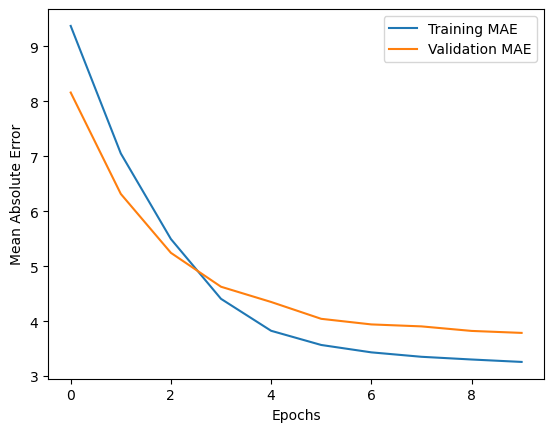

In [7]:
# Plot training results
import matplotlib.pyplot as plt

plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

17/17 [==============================] - 1s 76ms/step - loss: 17.9178 - mae: 2.8878
Test Loss: 17.9178, Test MAE: 2.8878
17/17 [==============================] - 2s 68ms/step


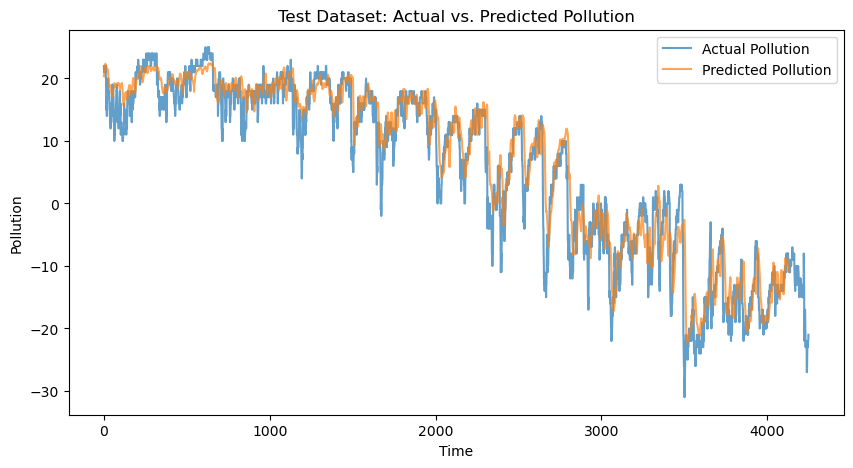

In [8]:
# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Generate predictions for the test dataset
predictions = model.predict(test_dataset)

# Plot actual vs. predicted temperature values
import matplotlib.pyplot as plt

actual_temperatures = temperature[num_train_samples + num_val_samples + delay : num_train_samples + num_val_samples + num_test_samples]

plt.figure(figsize=(10, 5))
plt.plot(actual_temperatures, label="Actual Pollution", alpha=0.7)
plt.plot(predictions, label="Predicted Pollution", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Pollution")
plt.legend()
plt.title("Test Dataset: Actual vs. Predicted Pollution")
plt.show()